## Option Pricing with Monte Carlo Simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(42)

## European and Asian Call Option

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class MonteCarloOptionPricer:
    def __init__(self, S0, K, r, sigma, T, N, M):
        self.S0 = S0        # Initial stock price
        self.K = K          # Strike price
        self.r = r          # Risk-free rate
        self.sigma = sigma  # Volatility
        self.T = T          # Maturity
        self.N = N          # Number of paths
        self.M = M          # Number of time steps
        self.dt = T / M     # Time increment
        self.paths = None   # To store simulated GBM paths

    def generate_paths(self):
        S = np.zeros((self.N, self.M + 1))
        S[:, 0] = self.S0

        Z_half = np.random.normal(size=(self.N, self.M // 2))
        Z_antithetic = -Z_half
        Z = np.concatenate((Z_half, Z_antithetic), axis=1)

        for t in range(1, self.M + 1):
            S[:, t] = S[:, t-1] * np.exp((self.r - 0.5 * self.sigma**2) * self.dt + self.sigma * np.sqrt(self.dt) * Z[:, t-1])

        self.paths = S
        return S

    def european_call_price(self):
        if self.paths is None:
            self.generate_paths()
        S_T = self.paths[:, -1]
        payoff = np.maximum(S_T - self.K, 0)
        discounted_payoff = np.exp(-self.r * self.T) * payoff
        price = np.mean(discounted_payoff)
        return price

    def asian_call_price(self):
        if self.paths is None:
            self.generate_paths()
        S_avg = np.mean(self.paths[:, 1:], axis=1)
        payoff = np.maximum(S_avg - self.K, 0)
        discounted_payoff = np.exp(-self.r * self.T) * payoff
        price = np.mean(discounted_payoff)
        return price

    def plot_paths(self, num_paths=10):
        if self.paths is None:
            self.generate_paths()
        time_grid = np.linspace(0, self.T, self.M + 1)
        plt.figure(figsize=(10, 6))
        for i in range(min(num_paths, self.N)):
            plt.plot(time_grid, self.paths[i], lw=1)
        plt.title(f"Simulated GBM Paths (S₀={self.S0}, σ={self.sigma})")
        plt.xlabel("Time")
        plt.ylabel("Stock Price")
        plt.grid(True)
        plt.show()


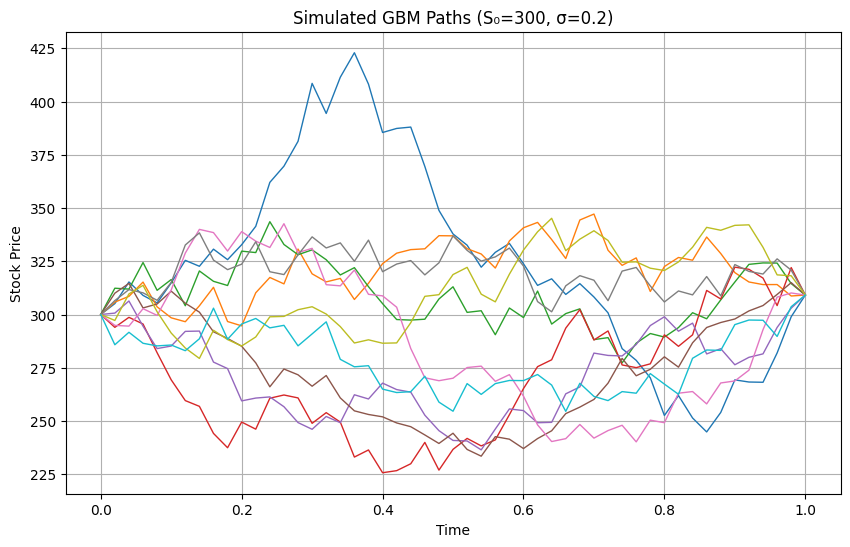

European Call Price: 8.6907746418124
Asian Call Price: 11.2751879339837


In [3]:
pricer = MonteCarloOptionPricer(S0=300, K=300, r=0.05, sigma=0.2, T=1.0, N=10000, M=50)
pricer.generate_paths()
pricer.plot_paths(num_paths=10)

print("European Call Price:", pricer.european_call_price())
print("Asian Call Price:", pricer.asian_call_price())


We can get the Put price from the Put-Call Parity formula

## Bermudan Call Option

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

class BermudanOptionPricer:
    def __init__(self, S0, K, r, sigma, T, M, N, exercise_dates):
        self.S0 = S0          # initial stock price
        self.K = K            # strike price
        self.r = r            # risk-free rate
        self.sigma = sigma    # volatility
        self.T = T            # maturity
        self.M = M            # time steps
        self.N = N            # outer paths
        self.dt = T / M       # time step size
        self.exercise_idxs = [int(d * M) for d in exercise_dates]  # convert to step indices
        self.paths = None

    def simulate_paths(self):
        S = np.zeros((self.N, self.M + 1))
        S[:, 0] = self.S0

        Z_half = np.random.normal(size=(self.N, self.M // 2))
        Z_full = np.concatenate([Z_half, -Z_half], axis=1)

        for t in range(1, self.M + 1):
            S[:, t] = S[:, t - 1] * np.exp((self.r - 0.5 * self.sigma**2) * self.dt + self.sigma * np.sqrt(self.dt) * Z_full[:, t - 1])

        self.paths = S
        return S

    def price_lsm(self):
        if self.paths is None:
            self.simulate_paths()

        cashflows = np.maximum(self.paths[:, -1] - self.K, 0)
        discount = np.exp(-self.r * self.dt)

        for t in reversed(self.exercise_idxs[:-1]):
            itm = self.paths[:, t] > self.K  # in-the-money paths
            X = self.paths[itm, t].reshape(-1, 1)
            Y = cashflows[itm] * discount  # discounted future cashflows

            if len(X) == 0:
                continue

            model = LinearRegression().fit(np.column_stack([X, X**2]), Y)
            continuation = model.predict(np.column_stack([X, X**2]))

            exercise = np.maximum(self.paths[itm, t] - self.K, 0)
            exercise_now = exercise > continuation
            cashflows[itm] = np.where(exercise_now, exercise, Y)

            cashflows = cashflows * discount

        return np.mean(cashflows)

    def plot_paths(self, n_paths=10):
        if self.paths is None:
            self.simulate_paths()
        t = np.linspace(0, self.T, self.M + 1)
        plt.figure(figsize=(10, 5))
        for i in range(min(n_paths, self.N)):
            plt.plot(t, self.paths[i])
        plt.axhline(self.K, color='black', linestyle='--', label='Strike')
        plt.title("Simulated GBM Paths")
        plt.xlabel("Time")
        plt.ylabel("Stock Price")
        plt.grid(True)
        plt.legend()
        plt.show()


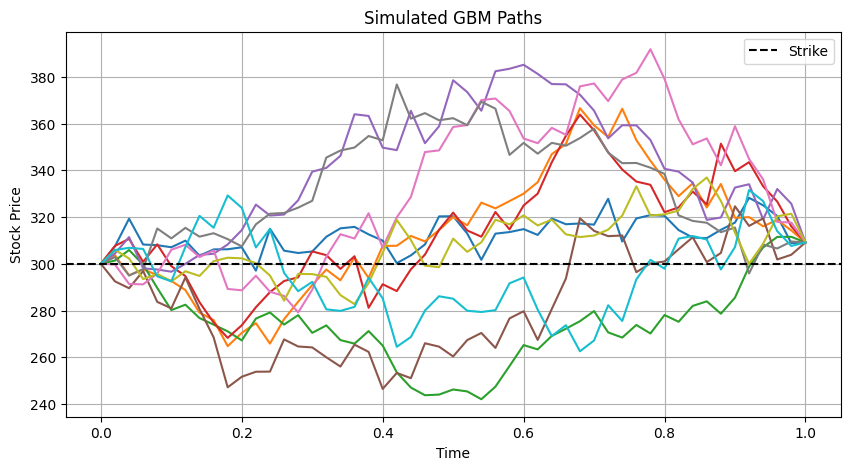

Bermudan Call Price (LSM): 28.3941


In [5]:

bermudan_pricer = BermudanOptionPricer(S0=300, K=300, r=0.05, sigma=0.2, T=1.0, M=50, N=10000, exercise_dates=[0.25, 0.5, 0.75, 1.0])
# Simulate paths and plot a few
bermudan_pricer.simulate_paths()
bermudan_pricer.plot_paths(n_paths=10)

# Price using Longstaff-Schwartz method (LSM)
bermudan_price_lsm = bermudan_pricer.price_lsm()
print(f"Bermudan Call Price (LSM): {bermudan_price_lsm:.4f}")
